# XWTs_in_Model.ipynb

#!/usr/bin/env python
'''File name: XWTs_in_Model.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.05.2020
    Date last modified: 04.05.2020

    ############################################################## 
    Purpos:

    Load XWTs centroids that were created by running:
    /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/programs/XWTing/XWTs_search_ERA5.py

    1) Read the nescessary variables from the model in which XWTs should be searched for
    2) Bring the centroids and the model data to the common coarser resolution grid
    3) Preprocess the model data
    3) Calculate Eucledian Distances for each day
    4) Save the data

'''

In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata
from Functions_Extreme_WTs import EucledianDistance

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df


import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)


### Program Setup

In [2]:
Season='Annual' # ['AMJJAS', 'ONDJFM']

DW_Regions=['Bay_Area','Central_Coast','LA','Modoc','Northeast','San_Diego','Siearas_East','Siearas_West']
sSubregionPR='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/' #+Regions[sRegion]

SelVar = np.array([['RH2AVG','MF2AVG','V850'],
         ['T2AVG','T2MIN','RH2AVG'],
         ['MR2AVG','SLPAVG','WSPD10'],
         ['T2MIN','U10AVG','U500'],
         ['RH500','T2AVG','T500'],
         ['MF2AVG','PWAVG','V200'],
         ['T2MIN','T500','WSPD500'],
         ['RH2AVG','V500','WSPD200']])

E5Vars=['CAPE','CIN','LCL','LFC','MF2AVG','MF500','MF850','MR2AVG','MR500','MR850','PWAVG','RH2AVG',\
        'RH500','RH850','SLPAVG','T2AVG','T2MAX','T2MIN','T500','T850','U10AVG','U200','U500','U850',\
        'V10AVG','V200','V500','V850','WSPD10','WSPD200','WSPD500','WSPD850','Z500']
E20Vars = ['CAPE','CIN','LCL','LFC','MF2AVG','FLX500','FLX850','Q2','Q500','Q850','PW','RH2',\
           'RH500','RH850','PSL','T2','T2MAX','T2min','T500','T850','U10','U200','U500','U850',\
           'V10','V200','V500','V850','UV10','UV200','UV500','UV850','ZG500']

sPlotDir='/glade/u/home/prein/papers/Extreme-WTs-US/plots/ERA20C_XWTs/'# +str(iNrOfExtremes)+'_Events/'

Nr_XWTs = [4,3,10,8,4,4,6,15,8]

YYYY_stamp = '2001-2019'
Season = 'Annual'
FireObs = 'MODIS'
REANAL = 'ERA5'

In [13]:
Season='Annual' # ['AMJJAS', 'ONDJFM']

Data_All={}
for re in range(len(DW_Regions)):
    Region=DW_Regions[re]
    print('    process '+Region)

    Variables=SelVar[re,:]
    ExtrNR = Nr_XWTs[re]
        
    s = "-"; VarString=s.join(Variables)
    
    XWTdata='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/'+'Clusters'+str(ExtrNR)+'_'+Region+'_'+YYYY_stamp+'_'+VarString+'_'+Season+'_'+FireObs+'_'+REANAL
    sDataDir='/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_ERA20C/'
    sClusterSave=sDataDir+'Clusters'+str(ExtrNR)+'_'+Region+'_'+YYYY_stamp+'_'+VarString+'_'+Season+'_'+FireObs+'_'+REANAL
    
    # ### Load the centroids and shape file
    print('    Restore: '+XWTdata)
    with open(XWTdata, 'rb') as handle:
        npzfile = pickle.load(handle)
    XWTclusters=npzfile['grClustersFin']['Full']
    XWTlat=npzfile['LatWT']
    XWTlon=npzfile['LonWT']
    XWTtime=npzfile['rgdTime']
    SpatialSmoothing=npzfile['SpatialSmoothing']
    
    print('        Load shapefile')
    sf = shp.Reader(sSubregionPR+Region)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
    
    # ### Read ERA20C data
    ncid=Dataset('/glade/campaign/mmm/c3we/prein/ERA-20C/CAPE/CAPE_daymean_2010.nc', mode='r') # open the netcdf file
    E20Lat=np.squeeze(ncid.variables['g4_lat_1'][:])
    E20Lon=np.squeeze(ncid.variables['g4_lon_2'][:])
    ncid.close()
    E20Lon[E20Lon>180]=E20Lon[E20Lon>180]-360
    E20Lon2D, E20Lat2D = np.meshgrid(E20Lon, E20Lat)
    
    
    rgrGridCells=[(E20Lon2D.ravel()[ii],E20Lat2D.ravel()[ii]) for ii in range(len(E20Lat2D.ravel()))]
    rgrSRactP=np.zeros((E20Lat2D.shape[0]*E20Lat2D.shape[1]))
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
    rgrSRactP=np.reshape(rgrSRactP, (E20Lat2D.shape[0], E20Lat2D.shape[1]))
    
    # get grid cells that cover the centroid
    N_XWT=np.max(XWTlat)
    S_XWT=np.min(XWTlat)
    E_XWT=np.max(XWTlon)
    W_XWT=np.min(XWTlon)
    
    # ERA-20C area that contains this region
    E20_W=np.where(np.max((E20Lon2D <= W_XWT), axis=0) == 1)[0][-1]+1 #-1
    E20_E=np.where(np.max((E20Lon2D <= E_XWT), axis=0) == 1)[0][-1]+1
    E20_S=np.where(np.max((E20Lat2D <= S_XWT), axis=1) == 1)[0][0]-1
    E20_N=np.where(np.max((E20Lat2D <= N_XWT), axis=1) == 1)[0][0] #-1
    
    # # Cut out Lat and Lon
    E20Lon2D=E20Lon2D[E20_N:E20_S,E20_W:E20_E]
    E20Lat2D=E20Lat2D[E20_N:E20_S,E20_W:E20_E]
    
    
    # ### Bring data to same grid
    if XWTlat.shape[0]*XWTlon.shape[0] > E20Lat2D.shape[0]*E20Lat2D.shape[1]:
        # we remap the centroids to the model grid
        Clusters=np.reshape(XWTclusters[0],(XWTclusters[0].shape[0],XWTlat.shape[0],XWTlon.shape[1],len(Variables)))
        RemappedClusters=np.zeros((Clusters.shape[0],E20Lat2D.shape[0],E20Lat2D.shape[1],Clusters.shape[3]))
        
        [Y,X]=(XWTlon, XWTlat)
        [Yi,Xi]=(E20Lon2D,E20Lat2D)
        xy=np.zeros([X.shape[0]*X.shape[1],2])
        xy[:,0]=Y.flatten()
        xy[:,1]=X.flatten()
        uv=np.zeros([Xi.shape[0]*Xi.shape[1],2])
        uv[:,0]=Yi.flatten()
        uv[:,1]=Xi.flatten()
        #Computed once and for all !
        vtx, wts = interp_weights(xy, uv)
        
        for cl in range(Clusters.shape[0]):
            for va in range(len(Variables)):
                values=Clusters[cl,:,:,va]
                valuesi=interpolate(values.flatten(), vtx, wts)
                RemappedClusters[cl,:,:,va]=valuesi.reshape(Xi.shape[0],Xi.shape[1])
        # we have to renormalize the clusters
        Normalized=(RemappedClusters-np.mean(RemappedClusters, axis=(1,2))[:,None,None,:])
        Normalized=Normalized/np.std(Normalized, axis=(1,2))[:,None,None,:]
        ClusterPrepared=(np.reshape(Normalized, (Normalized.shape[0],Normalized.shape[1]*Normalized.shape[2]*Normalized.shape[3])),XWTclusters[1])
    else:
        print('    Remapping the model data to the centroid grid is not implemented yet!')
        stop()
    
    # Read E20C
    dStartDayE20=datetime.datetime(1900, 1, 1,0)
    dStopDayE20=datetime.datetime(2010, 12, 31,23)
    E20_time = pd.date_range(dStartDayE20, end=dStopDayE20, freq='d')
    E20YYYY=np.unique(E20_time.year)
    
    E20_DATA=np.zeros((len(E20_time),E20Lon2D.shape[0],E20Lon2D.shape[1], len(Variables))); E20_DATA[:]=np.nan
    for yy in range(len(E20YYYY)):
        DDact=(E20_time.year == E20YYYY[yy])
        for va in range(len(Variables)):
            VARact = E20Vars[E5Vars.index(Variables[va])]
            FILE=glob.glob('/glade/campaign/mmm/c3we/prein/ERA-20C/'+VARact+'/daymean/'+VARact+'_daymean*_'+str(E20YYYY[yy])+'.nc')[0]
            ncid=Dataset(FILE, mode='r') # open the netcdf file
            E20_DATA[DDact,:,:,va]=np.squeeze(ncid.variables[VARact][:,E20_N:E20_S,E20_W:E20_E])
            ncid.close()

    DailyVarsEvalNorm=PreprocessWTdata(E20_DATA,                  # WT data [time,lat,lon,var]
                               RelAnnom=1,                     # calculate relative anomalies [1-yes; 0-no]
                               SmoothSigma=SpatialSmoothing,   # Smoothing stddev (Gaussian smoothing)
                               RemoveAnnualCycl=1,             # remove annual cycle [1-yes; 0-no]
                               NormalizeData=1)                # normalize data [1-yes; 0-no]
    
    EucledianDist, Correlation =EucledianDistance(DailyVarsEvalNorm,
                                                  ClusterPrepared)
    EucledianDist_orig=np.copy(EucledianDist)
    EucledianDist=np.min(EucledianDist,axis=1)
    
    EDspace=np.linspace(EucledianDist.min(),np.percentile(EucledianDist,0.2),100)
    ChangeInFr=np.zeros((len(EDspace)))
    RP=np.zeros((len(EDspace)))
    ClimLen=40
    
    for ed in range(len(EDspace)):
        TEST=(EucledianDist < EDspace[ed])
        ExtrFrY=float(np.sum(TEST))/len(E20YYYY)
        ExpectedFrequency=np.cumsum(np.array([ExtrFrY]*len(E20YYYY)))
        RP[ed]=ExtrFrY
        TEST=np.array([np.sum(TEST[E20_time.year == E20YYYY[yy]]) for yy in range(len(E20YYYY))])
        TEST=np.cumsum(TEST, dtype=float)
    
        Ref=(TEST[ClimLen]-TEST[0])
        Cur=(TEST[-1]-TEST[-ClimLen])
        ChangeInFr[ed]=((Cur-Ref)/float(Ref))*100
    
    
    # In[37]:
    # calculate random chance
    try:
        RandomChance
    except:
        BSnr=1000
        RandomChance=np.zeros((len(RP),BSnr))
        for pe in range(len(RP)):
            NrOfEvents=(RP*len(E20YYYY))[pe]
            for bs in range(BSnr):
                RandomDays=np.sort(np.array([random.randint(0, len(E20YYYY)-1) for ii in range(int(NrOfEvents))]))
                RandRecord=np.zeros((len(E20YYYY)))
                for ii in range(len(RandomDays)):
                    RandRecord[RandomDays[ii]]=RandRecord[RandomDays[ii]]+1
                Ref=np.sum(RandRecord[:ClimLen])
                Cur=np.sum(RandRecord[-ClimLen:])
                RandomChance[pe,bs]=((Cur-Ref)/float(Ref))*100

    Data_reg={'EucledianDist_orig':EucledianDist_orig,
              'ChangeInFr':ChangeInFr,
              'RP':RP,
              'RandomChance':RandomChance,
              'E20_time':E20_time}
    Data_All[Region]=Data_reg

# Save the data
afile = open(sDataDir+'ERA20C_XWTs_Eucledian-Distances.pkl', 'wb')
pickle.dump(Data_All, afile)
afile.close()

    process Bay_Area
    Restore: /glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/Clusters4_Bay_Area_2001-2019_RH2AVG-MF2AVG-V850_Annual_MODIS_ERA5
        Load shapefile
    process Central_Coast
    Restore: /glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/Clusters3_Central_Coast_2001-2019_T2AVG-T2MIN-RH2AVG_Annual_MODIS_ERA5
        Load shapefile
    process LA
    Restore: /glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/Clusters10_LA_2001-2019_MR2AVG-SLPAVG-WSPD10_Annual_MODIS_ERA5
        Load shapefile
    process Modoc
    Restore: /glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/Clusters8_Modoc_2001-2019_T2MIN-U10AVG-U500_Annual_MODIS_ERA5
        Load shapefile
    process Northeast
    Restore: /glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/Clusters4_Northeast_2001-2019_RH500-T2AVG-T500_Annual_MODIS_ERA5
        Load shapefile
    process San_Diego
    Restore: /glade/campaign/mmm/c

In [12]:
glob.glob('/glade/campaign/mmm/c3we/prein/ERA-20C/'+VARact+'/daymean/'+VARact+'_daymean*_'+str(E20YYYY[yy])+'.nc')[0]

'/glade/campaign/mmm/c3we/prein/ERA-20C/U10/daymean/U10_daymean_1900.nc'

### Plot the XWT centroids in ERA5 and ERA-20C

selected day is 1970-08-26 00:00:00
        Plot map to: /glade/u/home/prein/papers/Extreme-WTs-US/plots/ERA20C_XWTs/Example_ERA20C-XWT1-LA.pdf


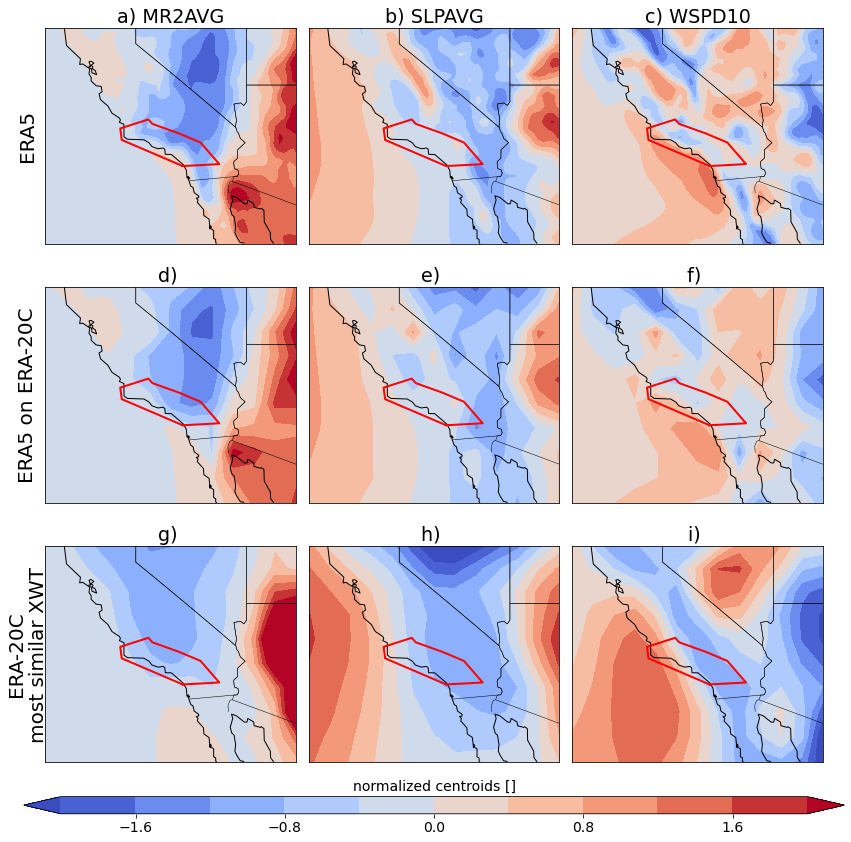

In [73]:
from mpl_toolkits.basemap import Basemap, cm
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,12))
plt.rcParams.update({'font.size': 16})
rgsLableABC=list(string.ascii_lowercase)

WTSEL=1
SEL = np.argsort(EucledianDist_orig, axis=0)[0,WTSEL]
print('selected day is '+str(E20_time[SEL]))

gs2 = gridspec.GridSpec(3,3)
gs2.update(left=0.05, right=0.95,
       bottom=0.10, top=0.95,
       wspace=0.05, hspace=0.20)

m = Basemap(projection='cea',\
            llcrnrlat= np.min(E20Lat2D) ,urcrnrlat=np.max(E20Lat2D),\
            llcrnrlon=np.min(E20Lon2D),urcrnrlon=np.max(E20Lon2D),resolution='l', fix_aspect=False)
xi, yi = m(XWTlon,XWTlat)
for va in range(3):
    ax = plt.subplot(gs2[0,va])
    cs1= plt.contourf(xi, yi, Clusters[WTSEL,:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    plt.title(rgsLableABC[va]+') '+SelVar[re][va])
    if va == 0:
        ax.text(-0.07,0.5, 'ERA5' , ha='center',va='center', rotation=90, \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20) #, weight='bold')

    
# REMAPPED XWTs
xi, yi = m(E20Lon2D,E20Lat2D)
for va in range(3):
    ax = plt.subplot(gs2[1,va])
    cs1= plt.contourf(xi, yi, RemappedClusters[WTSEL,:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    plt.title(rgsLableABC[va+3]+') ')
    if va == 0:
        ax.text(-0.07,0.5, 'ERA5 on ERA-20C' , ha='center',va='center', rotation=90, \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20) #, weight='bold')
    
# XWT days in ERA-20C
xi, yi = m(E20Lon2D,E20Lat2D)
for va in range(3):
    ax = plt.subplot(gs2[2,va])
    cs1= plt.contourf(xi, yi, DailyVarsEvalNorm[SEL,:,:,va], cmap='coolwarm',levels=np.linspace(-2,2,11),extend='both')
    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)
    plt.title(rgsLableABC[va+6]+') ')
    if va == 0:
        ax.text(-0.07,0.5, 'ERA-20C\nmost similar XWT' , ha='center',va='center', rotation=90, \
                transform = ax.transAxes, fontname="Times New Roman Bold", fontsize=20) #, weight='bold')
        
# add colorbar for centroids
CbarAx = axes([0.025, 0.04, 0.95, 0.02])
cb = colorbar(cs1, cax = CbarAx, orientation='horizontal', extend='both') #, ticks=np.arange(300,1600,200))
cb.ax.tick_params(labelsize=14)
cb.ax.set_title('normalized centroids []', fontsize=14)

sPlotFile=sPlotDir
# sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
sPlotName= 'Example_ERA20C-XWT'+str(WTSEL)+'-'+DW_Regions[re]+'.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

25804

### Bring data to same grid

In [8]:
EDspace=np.linspace(EucledianDist.min(),np.percentile(EucledianDist,0.2),100)
ChangeInFr=np.zeros((len(EDspace)))
RP=np.zeros((len(EDspace)))
ClimLen=40

for ed in range(len(EDspace)):
    TEST=(EucledianDist < EDspace[ed])
    ExtrFrY=float(np.sum(TEST))/len(E20YYYY)
    ExpectedFrequency=np.cumsum(np.array([ExtrFrY]*len(E20YYYY)))
    RP[ed]=ExtrFrY
    TEST=np.array([np.sum(TEST[E20_time.year == E20YYYY[yy]]) for yy in range(len(E20YYYY))])
    TEST=np.cumsum(TEST, dtype=float)

    Ref=(TEST[ClimLen]-TEST[0])
    Cur=(TEST[-1]-TEST[-ClimLen])
    ChangeInFr[ed]=((Cur-Ref)/float(Ref))*100

In [9]:
# calculatate random chance
BSnr=100
RandomChance=np.zeros((len(RP),BSnr))
for pe in range(len(RP)):
    NrOfEvents=(RP*len(E20YYYY))[pe]
    for bs in range(BSnr):
        RandomDays=np.sort(np.array([random.randint(0, len(E20YYYY)-1) for ii in range(int(NrOfEvents))]))
        RandRecord=np.zeros((len(E20YYYY)))
        for ii in range(len(RandomDays)):
            RandRecord[RandomDays[ii]]=RandRecord[RandomDays[ii]]+1
        Ref=np.sum(RandRecord[:ClimLen])
        Cur=np.sum(RandRecord[-ClimLen:])
        RandomChance[pe,bs]=((Cur-Ref)/float(Ref))*100

In [35]:
### Plot the PDF of ED and the significance of changes

(-300.0, 300.0)

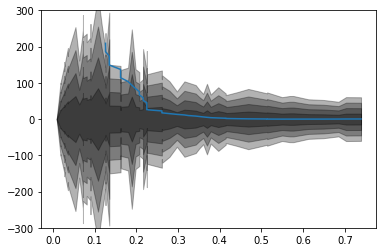

In [36]:
b = gaussian(40, 10)
Filtered = filters.convolve1d(ChangeInFr, b/b.sum())
RandomChance[RandomChance == np.inf]=np.nan

# calculate the standard deviation from random time series
Mean=np.mean(RandomChance, axis=1)
STD=np.std(RandomChance, axis=1)

Zscore=np.array([(Filtered[ii]-Mean[ii])/STD[ii] for ii in range(len(Filtered))])

plt.plot(RP,Filtered)
# [plt.plot(RP,RandomChance[:,bs],c='k',lw=0.1,alpha=0.1) for bs in range(RandomChance.shape[1])]
# plt.fill_between(RP,np.percentile(RandomChance,25,axis=1), np.percentile(RandomChance,75,axis=1), color='k', alpha=0.3)
plt.fill_between(RP,-np.nanstd(RandomChance,axis=1)*2, np.nanstd(RandomChance,axis=1)*2, color='k', alpha=0.3)
plt.fill_between(RP,-np.nanstd(RandomChance,axis=1)*1.5, np.nanstd(RandomChance,axis=1)*1.5, color='k', alpha=0.3)
plt.fill_between(RP,-np.nanstd(RandomChance,axis=1), np.nanstd(RandomChance,axis=1), color='k', alpha=0.3)
plt.fill_between(RP,-np.nanstd(RandomChance,axis=1)/2, np.nanstd(RandomChance,axis=1)/2, color='k', alpha=0.3)
plt.ylim([-300,300])
# plt.xlim([0,0.5])

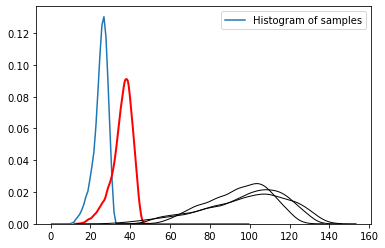

In [10]:
bins = np.linspace(0, 100, 100)
histogram, bins = np.histogram(EucledianDist, bins=bins, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])

# Compute the PDF on the bin centers from scipy distribution object
from scipy import stats
pdf = stats.norm.pdf(bin_centers)

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Histogram of samples")
plt.legend()


sns.distplot(EucledianDist*1/0.7, hist=False, kde=True, 
             bins=int(180/5), color = 'r', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

sns.distplot(npzfile['grEucledianDist']['Full'], hist=False, kde=True, 
             bins=int(180/5), color = 'k', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})
sns.distplot(npzfile['grEucledianDist']['SS1'], hist=False, kde=True, 
             bins=int(180/5), color = 'k', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})
sns.distplot(npzfile['grEucledianDist']['SS2'], hist=False, kde=True, 
             bins=int(180/5), color = 'k', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 1})
plt.show()